# pkasolver analysis
## Lindsay Shields
### October, 27, 2022

In this analysis, open source python package: pkasolver (https://github.com/mayrf/pkasolver), will be used to predict pKa values from a curated dataset. 

The objective of this analysis is to determine if pkasolver performs better than or as good as Chem Axons pka predictor. 

In [4]:
#import dependancies 
import pickle
import pandas as pd
from rdkit import Chem
import torch
from os import path
from io import BytesIO
import base64

#import analysis packages
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math
import numpy as np
from rdkit.Chem.MolStandardize import rdMolStandardize

#import pkasolver
import pkasolver
from pkasolver.query import QueryModel
from pkasolver.ml_architecture import GINPairV1
from pkasolver.query import draw_pka_map 
from pkasolver.query import calculate_microstate_pka_values, draw_pka_reactions
from IPython.display import display
from IPython.display import HTML

#load trained model
base_path=path.dirname(pkasolver.__file__)

#load for my sanity
import warnings
warnings.filterwarnings("ignore")

In [5]:
data=pd.read_csv('TestSet_fullData.csv')

In [6]:
#remove missing values from first pka sites (pkasolver)
df=data.dropna(subset=['PS_pKa0'])
df

,Compound,SMILES,num_sites,pka,PS_pKa0,PS_pKa1,PS_pKa2,PS_pKa3,PS_pKa4,PS_pKa5,...,PS_pKa8,Expt_pKa1,Expt_pKa2,Expt_pKa3,CA_pKa1,CA_pKa2,CA_pKa3,CA_pKa4,CA_pKa5,CA_pKa6
0,Acetic acid,CC(O)=O,1,[4.19],4.19,NaN,NaN,NaN,NaN,NaN,...,NaN,4.76,NaN,NaN,4.54,32.68,NaN,NaN,NaN,NaN
1,Phosphate,OP(O)(O)=O,1,[2.83],2.83,NaN,NaN,NaN,NaN,NaN,...,NaN,1.97,6.82,12.5,1.80,6.95,NaN,NaN,NaN,NaN
2,Methyl-Phosphate,COP(O)(O)=O,1,[2.56],2.56,NaN,NaN,NaN,NaN,NaN,...,NaN,1.54,6.31,NaN,1.83,6.85,NaN,NaN,NaN,NaN
3,Ethyl-Phosphate,CCOP(O)(=O)OCC,1,[4.66],4.66,NaN,NaN,NaN,NaN,NaN,...,NaN,1.60,6.62,NaN,1.95,NaN,NaN,NaN,NaN,NaN
4,Dimethyl-Phosphate,COP(O)(=O)OC,1,[4.06],4.06,NaN,NaN,NaN,NaN,NaN,...,NaN,1.29,NaN,NaN,2.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,propan-1-aminium,CCC[NH3+],1,[10.77],10.77,NaN,NaN,NaN,NaN,NaN,...,NaN,10.58,NaN,NaN,10.21,NaN,NaN,NaN,NaN,NaN
129,"propane-1,3-bis(aminium)",[NH3+]CCC[NH3+],1,[11.19],11.19,NaN,NaN,NaN,NaN,NaN,...,NaN,8.59,NaN,NaN,10.17,8.42,NaN,NaN,NaN,NaN
130,3-carboxypropan-1-aminium,[NH3+]CCCC(O)=O,2,"[5.07, 10.61]",5.07,10.61,NaN,NaN,NaN,NaN,...,NaN,10.43,NaN,NaN,4.53,10.22,NaN,NaN,NaN,NaN
131,3-sulfopropan-1-aminium,[NH3+]CCCS(O)(=O)=O,1,[9.65],9.65,NaN,NaN,NaN,NaN,NaN,...,NaN,10.05,NaN,NaN,10.19,27.02,NaN,NaN,NaN,NaN


### Plots

PearsonRResult(statistic=0.7717134507400567, pvalue=9.713345089822937e-26)


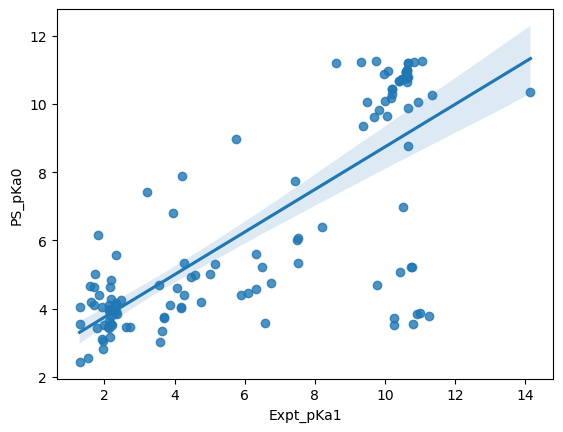

In [7]:
#pkasolver
sns.regplot(x=df['Expt_pKa1'],y=df['PS_pKa0'])
r=stats.pearsonr(df['Expt_pKa1'], df['PS_pKa0'])
print(r)

PearsonRResult(statistic=0.7743826610736287, pvalue=5.178592792188279e-26)


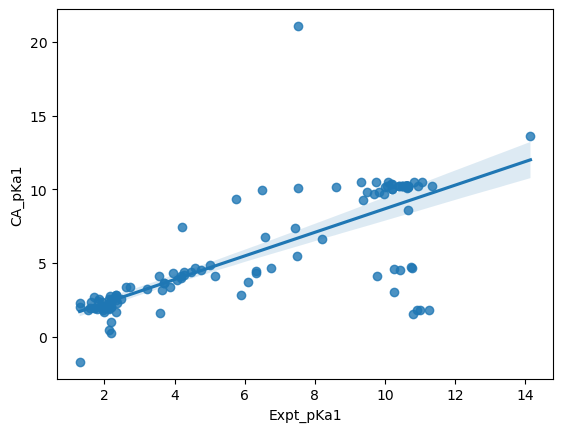

In [8]:
#Chem axon
sns.regplot(data=df,x='Expt_pKa1',y='CA_pKa1')
r=stats.pearsonr(df['Expt_pKa1'], df['CA_pKa1'])
print(r)

### Find better matching pka values

In [9]:
#make experimental subset
expt=df[['Expt_pKa1', 'Expt_pKa2', 'Expt_pKa3']]
ca=df[['CA_pKa1', 'CA_pKa2', 'CA_pKa3', 'CA_pKa4', 'CA_pKa5','CA_pKa6']]

#subtract number of missing values from total to get number of pka sites
expt_sites=3-(expt.isnull().sum(axis=1))
ca_sites=6-(ca.isnull().sum(axis=1))

#make new column to dataset
df['expt_sites']=expt_sites
df['ca_sites']=ca_sites

#### pkasolver

In [10]:
df['PS_selected_pka']=float()
df['Expt_selected_pka_ps']=float()

for i in df.index:

    ps_sites=df['num_sites'][i]
    ex_sites=df['expt_sites'][i]

    if ex_sites and ps_sites == 1:
        df['PS_selected_pka'][i]=df['PS_pKa0'][i]
        df['Expt_selected_pka_ps'][i]=df['Expt_pKa1'][i]
        
    elif ex_sites == 1 and ps_sites != 1:
        f=abs(df['Expt_pKa1'][i]-df['PS_pKa0'][i])
        s=abs(df['Expt_pKa1'][i]-df['PS_pKa1'][i])
        t=abs(df['Expt_pKa1'][i]-df['PS_pKa2'][i])
        tmp=[f,s,t]
        x=tmp.index(min(tmp))
        if x == 0:
            df['Expt_selected_pka_ps'][i]=df['Expt_pKa1'][i]
            df['PS_selected_pka'][i]=df['PS_pKa0'][i]
        elif x == 1:
            df['Expt_selected_pka_ps'][i]=df['Expt_pKa1'][i]
            df['PS_selected_pka'][i]=df['PS_pKa1'][i]
        elif x == 2:
            df['Expt_selected_pka_ps'][i]=df['Expt_pKa1'][i]
            df['PS_selected_pka'][i]=df['PS_pKa2'][i]
    elif ps_sites ==1 and ex_sites !=1:
        f=abs(df['PS_pKa0'][i]-df['Expt_pKa1'][i])
        s=abs(df['PS_pKa0'][i]-df['Expt_pKa2'][i])
        t=abs(df['PS_pKa0'][i]-df['Expt_pKa3'][i])
        tmp=[f,s,t]
        x=tmp.index(min(tmp))
        if x == 0:
            df['Expt_selected_pka_ps'][i]=df['Expt_pKa1'][i]
            df['PS_selected_pka'][i]=df['PS_pKa0'][i]
        elif x == 1:
            df['Expt_selected_pka_ps'][i]=df['Expt_pKa2'][i]
            df['PS_selected_pka'][i]=df['PS_pKa0'][i]
        elif x == 2:
            df['Expt_selected_pka_ps'][i]=df['Expt_pKa3'][i]
            df['PS_selected_pka'][i]=df['PS_pKa0'][i]
        
df

,Compound,SMILES,num_sites,pka,PS_pKa0,PS_pKa1,PS_pKa2,PS_pKa3,PS_pKa4,PS_pKa5,...,CA_pKa1,CA_pKa2,CA_pKa3,CA_pKa4,CA_pKa5,CA_pKa6,expt_sites,ca_sites,PS_selected_pka,Expt_selected_pka_ps
0,Acetic acid,CC(O)=O,1,[4.19],4.19,NaN,NaN,NaN,NaN,NaN,...,4.54,32.68,NaN,NaN,NaN,NaN,1,2,4.19,4.76
1,Phosphate,OP(O)(O)=O,1,[2.83],2.83,NaN,NaN,NaN,NaN,NaN,...,1.80,6.95,NaN,NaN,NaN,NaN,3,2,2.83,1.97
2,Methyl-Phosphate,COP(O)(O)=O,1,[2.56],2.56,NaN,NaN,NaN,NaN,NaN,...,1.83,6.85,NaN,NaN,NaN,NaN,2,2,2.56,1.54
3,Ethyl-Phosphate,CCOP(O)(=O)OCC,1,[4.66],4.66,NaN,NaN,NaN,NaN,NaN,...,1.95,NaN,NaN,NaN,NaN,NaN,2,1,4.66,1.60
4,Dimethyl-Phosphate,COP(O)(=O)OC,1,[4.06],4.06,NaN,NaN,NaN,NaN,NaN,...,2.00,NaN,NaN,NaN,NaN,NaN,1,1,4.06,1.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,propan-1-aminium,CCC[NH3+],1,[10.77],10.77,NaN,NaN,NaN,NaN,NaN,...,10.21,NaN,NaN,NaN,NaN,NaN,1,1,10.77,10.58
129,"propane-1,3-bis(aminium)",[NH3+]CCC[NH3+],1,[11.19],11.19,NaN,NaN,NaN,NaN,NaN,...,10.17,8.42,NaN,NaN,NaN,NaN,1,2,11.19,8.59
130,3-carboxypropan-1-aminium,[NH3+]CCCC(O)=O,2,"[5.07, 10.61]",5.07,10.61,NaN,NaN,NaN,NaN,...,4.53,10.22,NaN,NaN,NaN,NaN,1,2,10.61,10.43
131,3-sulfopropan-1-aminium,[NH3+]CCCS(O)(=O)=O,1,[9.65],9.65,NaN,NaN,NaN,NaN,NaN,...,10.19,27.02,NaN,NaN,NaN,NaN,1,2,9.65,10.05


PearsonRResult(statistic=0.9651336069021197, pvalue=7.190696031907549e-73)


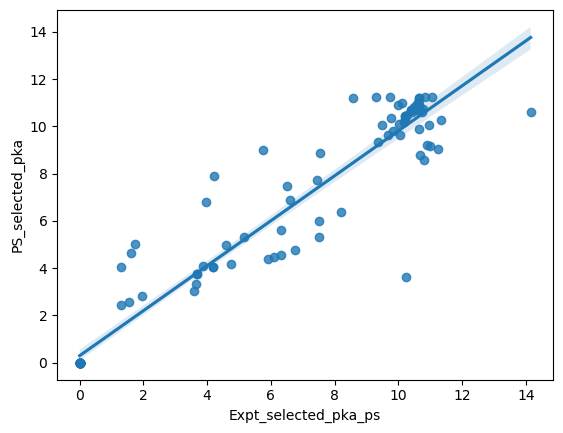

In [11]:
#plot regression
sns.regplot(x=df['Expt_selected_pka_ps'],y=df['PS_selected_pka'])
r=stats.pearsonr(df['Expt_selected_pka_ps'], df['PS_selected_pka'])
print(r)

In [12]:
#get mean square error 
ps_MSE=np.square(np.subtract(df['Expt_selected_pka_ps'],df['PS_selected_pka'])).mean()
print(ps_MSE)

1.500523387096774


#### Chem Axon

In [13]:
df['CA_selected_pka']=float()
df['Expt_selected_pka_ca']=float()

for i in df.index:

    ca_sites=df['ca_sites'][i]
    ex_sites=df['expt_sites'][i]

    if ex_sites and ca_sites == 1:
        df['CA_selected_pka'][i]=df['CA_pKa1'][i]
        df['Expt_selected_pka_ca'][i]=df['Expt_pKa1'][i]
        
    elif ex_sites == 1 and ca_sites != 1:
        f=abs(df['Expt_pKa1'][i]-df['CA_pKa1'][i])
        s=abs(df['Expt_pKa1'][i]-df['CA_pKa2'][i])
        t=abs(df['Expt_pKa1'][i]-df['CA_pKa3'][i])
        tmp=[f,s,t]
        x=tmp.index(min(tmp))
        if x == 0:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa1'][i]
            df['CA_selected_pka'][i]=df['CA_pKa1'][i]
        elif x == 1:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa1'][i]
            df['CA_selected_pka'][i]=df['CA_pKa2'][i]
        elif x == 2:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa1'][i]
            df['CA_selected_pka'][i]=df['CA_pKa3'][i]
    elif ca_sites ==1 and ex_sites !=1:
        f=abs(df['CA_pKa1'][i]-df['Expt_pKa1'][i])
        s=abs(df['CA_pKa1'][i]-df['Expt_pKa2'][i])
        t=abs(df['CA_pKa1'][i]-df['Expt_pKa3'][i])
        tmp=[f,s,t]
        x=tmp.index(min(tmp))
        if x == 0:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa1'][i]
            df['CA_selected_pka'][i]=df['CA_pKa1'][i]
        elif x == 1:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa2'][i]
            df['CA_selected_pka'][i]=df['CA_pKa1'][i]
        elif x == 2:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa3'][i]
            df['CA_selected_pka'][i]=df['CA_pKa1'][i]
    elif ca_sites and ex_sites !=1:
        f=abs(df['CA_pKa1'][i]-df['Expt_pKa1'][i])
        s=abs(df['CA_pKa1'][i]-df['Expt_pKa2'][i])
        t=abs(df['CA_pKa1'][i]-df['Expt_pKa3'][i])
        f2=abs(df['CA_pKa2'][i]-df['Expt_pKa1'][i])
        s2=abs(df['CA_pKa2'][i]-df['Expt_pKa2'][i])
        t2=abs(df['CA_pKa2'][i]-df['Expt_pKa3'][i])
        f3=abs(df['CA_pKa3'][i]-df['Expt_pKa1'][i])
        s3=abs(df['CA_pKa3'][i]-df['Expt_pKa2'][i])
        t3=abs(df['CA_pKa3'][i]-df['Expt_pKa3'][i])
        tmp=[f,s,t,f2,s2,t2,f3,s3,t3]
        x=tmp.index(min(tmp))
        if x == 0:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa1'][i]
            df['CA_selected_pka'][i]=df['CA_pKa1'][i]
        elif x == 1:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa2'][i]
            df['CA_selected_pka'][i]=df['CA_pKa1'][i]
        elif x == 2:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa3'][i]
            df['CA_selected_pka'][i]=df['CA_pKa1'][i]
        elif x == 3:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa1'][i]
            df['CA_selected_pka'][i]=df['CA_pKa2'][i]
        elif x == 4:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa2'][i]
            df['CA_selected_pka'][i]=df['CA_pKa2'][i]
        elif x == 5:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa3'][i]
            df['CA_selected_pka'][i]=df['CA_pKa2'][i]
        elif x == 6:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa1'][i]
            df['CA_selected_pka'][i]=df['CA_pKa3'][i]
        elif x == 7:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa2'][i]
            df['CA_selected_pka'][i]=df['CA_pKa3'][i]
        elif x == 8:
            df['Expt_selected_pka_ca'][i]=df['Expt_pKa3'][i]
            df['CA_selected_pka'][i]=df['CA_pKa3'][i]
        
df

,Compound,SMILES,num_sites,pka,PS_pKa0,PS_pKa1,PS_pKa2,PS_pKa3,PS_pKa4,PS_pKa5,...,CA_pKa3,CA_pKa4,CA_pKa5,CA_pKa6,expt_sites,ca_sites,PS_selected_pka,Expt_selected_pka_ps,CA_selected_pka,Expt_selected_pka_ca
0,Acetic acid,CC(O)=O,1,[4.19],4.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,2,4.19,4.76,4.54,4.76
1,Phosphate,OP(O)(O)=O,1,[2.83],2.83,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,2,2.83,1.97,6.95,6.82
2,Methyl-Phosphate,COP(O)(O)=O,1,[2.56],2.56,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2.56,1.54,1.83,1.54
3,Ethyl-Phosphate,CCOP(O)(=O)OCC,1,[4.66],4.66,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,1,4.66,1.60,1.95,1.60
4,Dimethyl-Phosphate,COP(O)(=O)OC,1,[4.06],4.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,4.06,1.29,2.00,1.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,propan-1-aminium,CCC[NH3+],1,[10.77],10.77,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,10.77,10.58,10.21,10.58
129,"propane-1,3-bis(aminium)",[NH3+]CCC[NH3+],1,[11.19],11.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,2,11.19,8.59,8.42,8.59
130,3-carboxypropan-1-aminium,[NH3+]CCCC(O)=O,2,"[5.07, 10.61]",5.07,10.61,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,2,10.61,10.43,10.22,10.43
131,3-sulfopropan-1-aminium,[NH3+]CCCS(O)(=O)=O,1,[9.65],9.65,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,2,9.65,10.05,10.19,10.05


PearsonRResult(statistic=0.9409700008984069, pvalue=3.0791436755949696e-59)


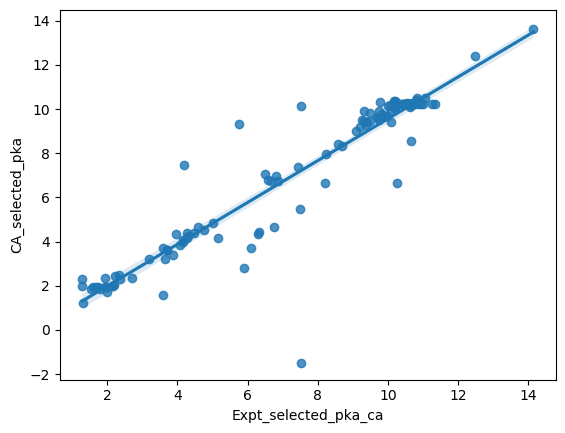

In [14]:
sns.regplot(x=df['Expt_selected_pka_ca'],y=df['CA_selected_pka'])
r=stats.pearsonr(df['Expt_selected_pka_ca'], df['CA_selected_pka'])
print(r)

In [15]:
#calculate mean square error for chem axon
ca_MSE=np.square(np.subtract(df['Expt_selected_pka_ca'],df['CA_selected_pka'])).mean()
print(ca_MSE)

1.4688420806451608


### Deal with compounds that could not get a pka prediction
November 1, 2022

In [16]:
#find compounds where a pka value could not be predicted
#i.e raised the ~Could not identify any ionizable group. Aborting.~ error
noPka=data[data['pka']=='[]']
#noPka.columnsmns
noPka.drop(columns=['PS_pKa0', 'PS_pKa1',
       'PS_pKa2', 'PS_pKa3', 'PS_pKa4', 'PS_pKa5', 'PS_pKa6', 'PS_pKa7',
       'PS_pKa8'],inplace=True)
noPka.dropna(axis=1,how='all',inplace=True)

In [17]:
noPka

,Compound,SMILES,num_sites,pka,Expt_pKa1,Expt_pKa2,CA_pKa1,CA_pKa2,CA_pKa3,CA_pKa4
6,n-Propyl-Phosphate,CCCOP(=O)(OCCC)OCCC,0,[],1.88,6.67,-9.06,NaN,NaN,NaN
7,n-Butyl-Phosphate,CCCCOP(=O)(OCCCC)OCCCC,0,[],1.80,6.84,-9.06,NaN,NaN,NaN
8,Di-n-propyl Phosphate,CCCOP(=O)(OCC)OCC,0,[],1.59,NaN,-9.06,NaN,NaN,NaN
78,Ammonia,N,0,[],9.21,NaN,8.86,NaN,NaN,NaN
81,Ammonium,[NH3+][H],0,[],9.25,NaN,8.86,NaN,NaN,NaN
82,Hydroxyammonium,[NH3+]O,0,[],5.96,NaN,3.94,26.17,17.65,-8.7
84,Hydrazinium,N[NH3+],0,[],8.12,NaN,9.24,NaN,NaN,NaN
106,Ammonium,[NH4+],0,[],9.25,NaN,8.86,NaN,NaN,NaN
107,sulfoazanium,[NH3+]S(O)(=O)=O,0,[],1.00,NaN,14.20,14.20,NaN,NaN


In [18]:
#send smiles list to tab deliminated format as input for opera and sparc
noPka[['Compound','SMILES']].to_csv('noPka.smi',sep='\t',index=False)

#### OPERA

In [19]:
opera=pd.read_csv('noPka-smi_OPERA2.8Pred.csv')
opera

,MoleculeID,pKa_a_exp,pKa_b_exp,ionization,pKa_a_pred,pKa_a_predRange,pKa_b_pred,pKa_b_predRange,AD_pKa,AD_index_pKa,Conf_index_pKa
0,CCCOP(=O)(OCCC)OCCC,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0.0000,0.0000
1,CCCCOP(=O)(OCCCC)OCCCC,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0.0000,0.0000
2,CCCOP(=O)(OCC)OCC,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0.0000,0.0000
3,N,NaN,NaN,1,NaN,NaN,6.91,[4.69:9.13],0,0.1330,0.1640
4,[NH3+]O,NaN,NaN,1,NaN,NaN,5.84,[5.41:6.27],0,0.1595,0.3395
5,N[NH3+],NaN,NaN,1,NaN,NaN,6.14,[4.98:7.3],0,0.1430,0.2750
6,[NH4+],NaN,NaN,1,NaN,NaN,6.91,[4.46:9.36],0,0.1250,0.1625
7,[NH3+]S(O)(=O)=O,NaN,NaN,1,2.95,[1.41:4.49],NaN,NaN,0,0.1620,0.1965


In [20]:
opera['OP_pKa']=''

for i in opera.index:
    acid=str(opera['pKa_a_pred'][i])
    base=str(opera['pKa_b_pred'][i])
    sites=opera['ionization'][i]
    
    if sites != 0:
        if acid == 'nan':
            opera['OP_pKa'][i]=base
        else:
            opera['OP_pKa'][i]=acid
    else:
        opera['OP_pKa'][i]=acid
opera   

,MoleculeID,pKa_a_exp,pKa_b_exp,ionization,pKa_a_pred,pKa_a_predRange,pKa_b_pred,pKa_b_predRange,AD_pKa,AD_index_pKa,Conf_index_pKa,OP_pKa
0,CCCOP(=O)(OCCC)OCCC,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0.0000,0.0000,nan
1,CCCCOP(=O)(OCCCC)OCCCC,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0.0000,0.0000,nan
2,CCCOP(=O)(OCC)OCC,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0.0000,0.0000,nan
3,N,NaN,NaN,1,NaN,NaN,6.91,[4.69:9.13],0,0.1330,0.1640,6.91
4,[NH3+]O,NaN,NaN,1,NaN,NaN,5.84,[5.41:6.27],0,0.1595,0.3395,5.84
5,N[NH3+],NaN,NaN,1,NaN,NaN,6.14,[4.98:7.3],0,0.1430,0.2750,6.14
6,[NH4+],NaN,NaN,1,NaN,NaN,6.91,[4.46:9.36],0,0.1250,0.1625,6.91
7,[NH3+]S(O)(=O)=O,NaN,NaN,1,2.95,[1.41:4.49],NaN,NaN,0,0.1620,0.1965,2.95


In [21]:
op=opera[['MoleculeID','OP_pKa']]

results=noPka.merge(op,left_on='SMILES',right_on='MoleculeID')
results.drop(columns='MoleculeID',inplace=True)
results

,Compound,SMILES,num_sites,pka,Expt_pKa1,Expt_pKa2,CA_pKa1,CA_pKa2,CA_pKa3,CA_pKa4,OP_pKa
0,n-Propyl-Phosphate,CCCOP(=O)(OCCC)OCCC,0,[],1.88,6.67,-9.06,NaN,NaN,NaN,nan
1,n-Butyl-Phosphate,CCCCOP(=O)(OCCCC)OCCCC,0,[],1.80,6.84,-9.06,NaN,NaN,NaN,nan
2,Di-n-propyl Phosphate,CCCOP(=O)(OCC)OCC,0,[],1.59,NaN,-9.06,NaN,NaN,NaN,nan
3,Ammonia,N,0,[],9.21,NaN,8.86,NaN,NaN,NaN,6.91
4,Hydroxyammonium,[NH3+]O,0,[],5.96,NaN,3.94,26.17,17.65,-8.7,5.84
5,Hydrazinium,N[NH3+],0,[],8.12,NaN,9.24,NaN,NaN,NaN,6.14
6,Ammonium,[NH4+],0,[],9.25,NaN,8.86,NaN,NaN,NaN,6.91
7,sulfoazanium,[NH3+]S(O)(=O)=O,0,[],1.00,NaN,14.20,14.20,NaN,NaN,2.95


#### SPARC

In [22]:
sparc=pd.read_csv("noPka_sparcResults_tab.csv")
sparc.dropna(axis=1,how='all',inplace=True)
sparc

,SMILES,Acid1,#,err,Base1,#.3,err.3
0,CCCOP(=O)(OCCC)OCCC,NaN,NaN,NaN,NaN,NaN,NaN
1,CCCCOP(=O)(OCCCC)OCCCC,NaN,NaN,NaN,NaN,NaN,NaN
2,CCCOP(=O)(OCC)OCC,NaN,NaN,NaN,NaN,NaN,NaN
3,N,NaN,NaN,NaN,9.243594,1.0,0.0
4,[N+]O,6.786572,2.0,0.377789,NaN,NaN,NaN
5,[N+]N,NaN,NaN,NaN,NaN,NaN,NaN
6,[N+],NaN,NaN,NaN,NaN,NaN,NaN
7,[N+]S(=O)(=O)O,0.778327,5.0,0.081370,NaN,NaN,NaN


In [23]:
sparc['SP_pKa']=''

for i in sparc.index:
    acid=str(sparc['Acid1'][i])
    base=str(sparc['Base1'][i])
    
    if acid and base == 'nan':
        sparc['SP_pKa'][i]=acid
    elif acid == 'nan'and base != 'nan':
        sparc['SP_pKa'][i]=base
    elif base == 'nan' and acid != 'nan':
        sparc['SP_pKa'][i]=acid
sparc  

,SMILES,Acid1,#,err,Base1,#.3,err.3,SP_pKa
0,CCCOP(=O)(OCCC)OCCC,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,CCCCOP(=O)(OCCCC)OCCCC,NaN,NaN,NaN,NaN,NaN,NaN,nan
2,CCCOP(=O)(OCC)OCC,NaN,NaN,NaN,NaN,NaN,NaN,nan
3,N,NaN,NaN,NaN,9.243594,1.0,0.0,9.243593512
4,[N+]O,6.786572,2.0,0.377789,NaN,NaN,NaN,6.786571709
5,[N+]N,NaN,NaN,NaN,NaN,NaN,NaN,nan
6,[N+],NaN,NaN,NaN,NaN,NaN,NaN,nan
7,[N+]S(=O)(=O)O,0.778327,5.0,0.081370,NaN,NaN,NaN,0.778327438


In [24]:
sp=sparc['SP_pKa']

results=results.join(sp, how ='left')
results

,Compound,SMILES,num_sites,pka,Expt_pKa1,Expt_pKa2,CA_pKa1,CA_pKa2,CA_pKa3,CA_pKa4,OP_pKa,SP_pKa
0,n-Propyl-Phosphate,CCCOP(=O)(OCCC)OCCC,0,[],1.88,6.67,-9.06,NaN,NaN,NaN,nan,nan
1,n-Butyl-Phosphate,CCCCOP(=O)(OCCCC)OCCCC,0,[],1.80,6.84,-9.06,NaN,NaN,NaN,nan,nan
2,Di-n-propyl Phosphate,CCCOP(=O)(OCC)OCC,0,[],1.59,NaN,-9.06,NaN,NaN,NaN,nan,nan
3,Ammonia,N,0,[],9.21,NaN,8.86,NaN,NaN,NaN,6.91,9.243593512
4,Hydroxyammonium,[NH3+]O,0,[],5.96,NaN,3.94,26.17,17.65,-8.7,5.84,6.786571709
5,Hydrazinium,N[NH3+],0,[],8.12,NaN,9.24,NaN,NaN,NaN,6.14,nan
6,Ammonium,[NH4+],0,[],9.25,NaN,8.86,NaN,NaN,NaN,6.91,nan
7,sulfoazanium,[NH3+]S(O)(=O)=O,0,[],1.00,NaN,14.20,14.20,NaN,NaN,2.95,0.778327438


In [25]:
results.to_csv('noPka_AllCal.csv',index=False)

### Add SPARC data

In [83]:
#drop the problem smiles
noProb=data.drop([27,34,35,47,48,66,72])

In [122]:
enumerator = rdMolStandardize.TautomerEnumerator()
uncharger = rdMolStandardize.Uncharger() 
  
s=[]
for i in data['SMILES']:
#for i in noProb['SMILES']:
    mol = Chem.MolFromSmiles(i)
    uncharged_mol = uncharger.uncharge(mol)
    cmol=enumerator.Canonicalize(uncharged_mol)
    #smi=Chem.MolToSmiles(cmol)
    s.append((Chem.MolToSmiles(cmol)))

data['SMILES_fix']=s

In [124]:
#noProb['SMILES_fix'].to_csv('InputForSparc.smi',sep='\t',index=False, header=False)
data['SMILES_fix'].to_csv('InputForSparc2.smi',sep='\t',index=False, header=False)

In [107]:
spaRes=pd.read_csv('TestData_noProblems_tab.csv',dtype=str)
spaRes

,SMILES,Acid1,Acid2,Acid3,Base1,Base2,Base3
0,CC(=O)O,4.761026743,NaN,NaN,NaN,NaN,NaN
1,O=P(O)(O)O,1.751735379,7.088801142,NaN,NaN,NaN,NaN
2,COP(=O)(O)O,1.10353146,6.392125133,NaN,NaN,NaN,NaN
3,CCOP(=O)(O)OCC,0.571475178,NaN,NaN,NaN,NaN,NaN
4,COP(=O)(O)OC,0.576021464,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
121,CCCN,10.39827481,NaN,NaN,NaN,NaN,NaN
122,NCCCN,7.994400824,10.45352089,NaN,NaN,NaN,NaN
123,NCCCC(=O)O,3.968129723,10.88152042,NaN,NaN,NaN,NaN
124,NCCCS(=O)(=O)O,10.66161458,NaN,NaN,NaN,NaN,NaN


In [108]:
#subtract number of missing values from total to get number of pka sites
sp_sites=6-(spaRes.isnull().sum(axis=1))

#make new column to dataset
spaRes['sp_sites']=sp_sites
spaRes

,SMILES,Acid1,Acid2,Acid3,Base1,Base2,Base3,sp_sites
0,CC(=O)O,4.761026743,NaN,NaN,NaN,NaN,NaN,1
1,O=P(O)(O)O,1.751735379,7.088801142,NaN,NaN,NaN,NaN,2
2,COP(=O)(O)O,1.10353146,6.392125133,NaN,NaN,NaN,NaN,2
3,CCOP(=O)(O)OCC,0.571475178,NaN,NaN,NaN,NaN,NaN,1
4,COP(=O)(O)OC,0.576021464,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...
121,CCCN,10.39827481,NaN,NaN,NaN,NaN,NaN,1
122,NCCCN,7.994400824,10.45352089,NaN,NaN,NaN,NaN,2
123,NCCCC(=O)O,3.968129723,10.88152042,NaN,NaN,NaN,NaN,2
124,NCCCS(=O)(=O)O,10.66161458,NaN,NaN,NaN,NaN,NaN,1


In [109]:
spaRes.dropna(axis=1,how='all',inplace=True)

In [110]:
res=noProb.merge(spaRes,left_on='SMILES_fix',right_on='SMILES')
res

,Compound,SMILES_x,num_sites,pka,PS_pKa0,PS_pKa1,PS_pKa2,PS_pKa3,PS_pKa4,PS_pKa5,...,CA_pKa5,CA_pKa6,SMILES_fix,SMILES_y,Acid1,Acid2,Acid3,Base1,Base2,sp_sites
0,Acetic acid,CC(O)=O,1,[4.19],4.19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,CC(=O)O,CC(=O)O,4.761026743,NaN,NaN,NaN,NaN,1
1,Phosphate,OP(O)(O)=O,1,[2.83],2.83,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,O=P(O)(O)O,O=P(O)(O)O,1.751735379,7.088801142,NaN,NaN,NaN,2
2,Methyl-Phosphate,COP(O)(O)=O,1,[2.56],2.56,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,COP(=O)(O)O,COP(=O)(O)O,1.10353146,6.392125133,NaN,NaN,NaN,2
3,Ethyl-Phosphate,CCOP(O)(=O)OCC,1,[4.66],4.66,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,CCOP(=O)(O)OCC,CCOP(=O)(O)OCC,0.571475178,NaN,NaN,NaN,NaN,1
4,Dimethyl-Phosphate,COP(O)(=O)OC,1,[4.06],4.06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,COP(=O)(O)OC,COP(=O)(O)OC,0.576021464,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,decan-1-aminium,CCCCCCCCCC[NH3+],1,[10.76],10.76,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,CCCCCCCCCCN,CCCCCCCCCCN,10.39827481,NaN,NaN,NaN,NaN,1
160,10-sulfodecan-1-aminium,[NH3+]CCCCCCCCCCS(O)(=O)=O,1,[10.25],10.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NCCCCCCCCCCS(=O)(=O)O,NCCCCCCCCCCS(=O)(=O)O,0.370918459,10.39800063,NaN,NaN,NaN,2
161,(10-azaniumyldecyl)phosphonate,[NH3+]CCCCCCCCCCP([O-])([O-])=O,3,"[3.8, 3.88, 9.06]",3.80,3.88,9.06,NaN,NaN,NaN,...,NaN,NaN,NCCCCCCCCCCP(=O)(O)O,NCCCCCCCCCCP(=O)(O)O,2.827097705,8.16119021,10.4067429,NaN,NaN,3
162,3-carboxypropan-1-aminium,[NH3+]CCCC(O)=O,2,"[5.07, 10.61]",5.07,10.61,NaN,NaN,NaN,NaN,...,NaN,NaN,NCCCC(=O)O,NCCCC(=O)O,3.968129723,10.88152042,NaN,NaN,NaN,2


In [114]:
expt=noProb[['Expt_pKa1', 'Expt_pKa2', 'Expt_pKa3']]
expt_sites=3-(expt.isnull().sum(axis=1))

res['expt_sites']=expt_sites

In [112]:
res['SP_selected_pka']=float()
res['Expt_selected_pka_ca']=float()

for i in res.index:

    sp_sites=res['sp_sites'][i]
    ex_sites=res['expt_sites'][i]

    if ex_sites and sp_sites == 1:
        res['SP_selected_pka'][i]=res['Acid1'][i]
        res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
        
    elif ex_sites == 1 and sp_sites != 1:
        f=abs(res['Expt_pKa1'][i]-res['Acid1'][i])
        s=abs(res['Expt_pKa1'][i]-res['Acid2'][i])
        t=abs(res['Expt_pKa1'][i]-res['Acid3'][i])
        fr=abs(res['Expt_pKa1'][i]-res['Base1'][i])
        ff=abs(res['Expt_pKa1'][i]-res['Base2'][i])
        tmp=[f,s,t,fr,ff]
        x=tmp.index(min(tmp))
        if x == 0:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Acid1'][i]
        elif x == 1:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Acid2'][i]
        elif x == 2:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Acid3'][i]
        elif x == 3:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Base1'][i]
        elif x == 4:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Base2'][i]
    elif sp_sites ==1 and ex_sites !=1:
        f=abs(res['Acid1'][i]-res['Expt_pKa1'][i])
        s=abs(res['Acid1'][i]-res['Expt_pKa2'][i])
        t=abs(res['Acid1'][i]-res['Expt_pKa3'][i])
        tmp=[f,s,t]
        x=tmp.index(min(tmp))
        if x == 0:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Acid1'][i]
        elif x == 1:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa2'][i]
            res['SP_selected_pka'][i]=res['Acid1'][i]
        elif x == 2:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa3'][i]
            res['SP_selected_pka'][i]=res['Acid1'][i]
    elif sp_sites and ex_sites !=1:
        f=abs(res['Acid1'][i]-res['Expt_pKa1'][i])
        s=abs(res['Acid1'][i]-res['Expt_pKa2'][i])
        t=abs(res['Acid1'][i]-res['Expt_pKa3'][i])
        f2=abs(res['Acid2'][i]-res['Expt_pKa1'][i])
        s2=abs(res['Acid2'][i]-res['Expt_pKa2'][i])
        t2=abs(res['Acid2'][i]-res['Expt_pKa3'][i])
        f3=abs(res['Acid3'][i]-res['Expt_pKa1'][i])
        s3=abs(res['Acid3'][i]-res['Expt_pKa2'][i])
        t3=abs(res['Acid3'][i]-res['Expt_pKa3'][i])
        f4=abs(res['Base1'][i]-res['Expt_pKa1'][i])
        s4=abs(res['Base1'][i]-res['Expt_pKa2'][i])
        t4=abs(res['Base1'][i]-res['Expt_pKa3'][i])
        f5=abs(res['Base2'][i]-res['Expt_pKa1'][i])
        s5=abs(res['Base2'][i]-res['Expt_pKa2'][i])
        t5=abs(res['Base2'][i]-res['Expt_pKa3'][i])
        tmp=[f,s,t,f2,s2,t2,f3,s3,t3,f4,s4,t4,f5,s5,t5]
        x=tmp.index(min(tmp))
        if x == 0:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Acid1'][i]
        elif x == 1:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa2'][i]
            res['SP_selected_pka'][i]=res['Acid1'][i]
        elif x == 2:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa3'][i]
            res['SP_selected_pka'][i]=res['Acid1'][i]
        elif x == 3:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Acid2'][i]
        elif x == 4:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa2'][i]
            res['SP_selected_pka'][i]=res['Acid2'][i]
        elif x == 5:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa3'][i]
            res['SP_selected_pka'][i]=res['Acid2'][i]
        elif x == 6:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Acid3'][i]
        elif x == 7:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa2'][i]
            res['SP_selected_pka'][i]=res['Acid3'][i]
        elif x == 8:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa3'][i]
            res['SP_selected_pka'][i]=res['Acid3'][i]
        elif x == 9:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Base1'][i]
        elif x == 10:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa2'][i]
            res['SP_selected_pka'][i]=res['Base1'][i]
        elif x == 11:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa3'][i]
            res['SP_selected_pka'][i]=res['Base1'][i]
        elif x == 12:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa1'][i]
            res['SP_selected_pka'][i]=res['Base2'][i]
        elif x == 13:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa2'][i]
            res['SP_selected_pka'][i]=res['Base2'][i]
        elif x == 14:
            res['Expt_selected_pka_ca'][i]=res['Expt_pKa3'][i]
            res['SP_selected_pka'][i]=res['Base2'][i]
res

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U11'), dtype('float64')) -> None

In [47]:
#fix smiles
inptForSparc['SMILES'].iloc[72]='NC(CC1=CNC2=CC=CC=C12)C(O)=O'
inptForSparc['SMILES'].iloc[66]='NC(CC1=CN=CN1)C(O)=O'
inptForSparc['SMILES'].iloc[48]="O=C(O)C(NC(=O)CCN)CC1=CN=CN1"
inptForSparc['SMILES'].iloc[35]="O=N(=O)C=1C=CC=C(C1O)N(=O)=O"
inptForSparc['SMILES'].iloc[34]="O=N(=O)C=1C=CC(O)=C(C1)N(=O)=O"
inptForSparc['SMILES'].iloc[27]='OC1=CC=NC=C1'


NameError: name 'inptForSparc' is not defined

In [119]:
data['SMILES'][[27,34,35,47,48,66,72]]

27                                OC1=CC=NC=C1
34    OC1=C(C=C(C=C1)[N+]([O-])=O)[N+]([O-])=O
35      OC1=C(C=CC=C1[N+]([O-])=O)[N+]([O-])=O
47              C1=C(NC=N1)CC(C(=O)O)NC(=O)CCN
48                NCCC(=O)NC(CC1=CN=CN1)C(O)=O
66                        NC(CC1=CN=CN1)C(O)=O
72                NC(CC1=CNC2=CC=CC=C12)C(O)=O
Name: SMILES, dtype: object